In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm

In [22]:
class PricingEnvironment:
    def __init__(self, cost, prices):
        self.cost = cost
        self.prices = prices
        self.v_t = stats.uniform(0.01, 1)

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t
    
    def conversion_probability(self, price):
        return 1 - self.v_t.cdf(price)

In [14]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [15]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [16]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

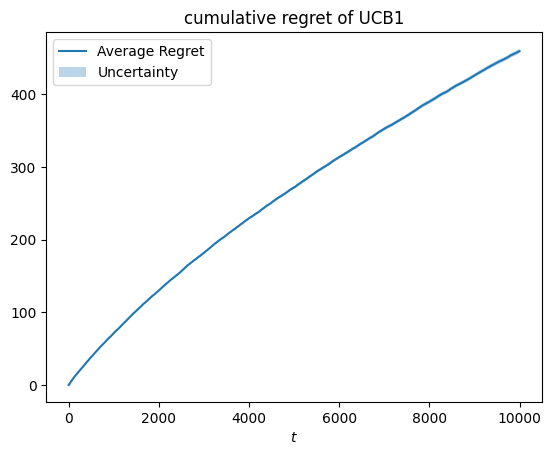

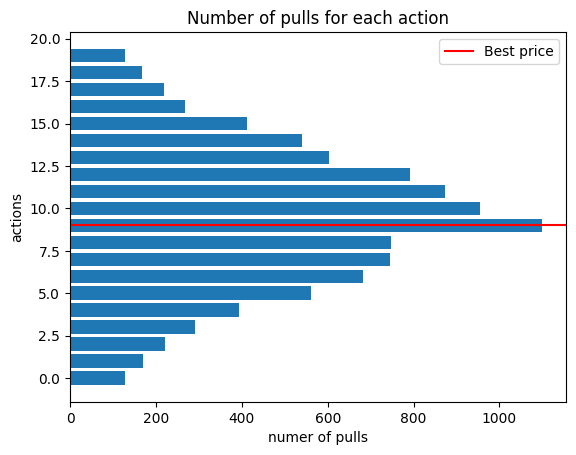

In [25]:
T = 10000
epsilon = T**(-0.33)
K = int(1/epsilon)
min_price, max_price = 0.01, 1
n_customers = 1
cost = 0
prices = np.linspace(min_price, max_price, K) 
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    ucb_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(seed)
    env = PricingEnvironment(cost=cost, prices=prices)

    many_prices = np.linspace(min_price, max_price, K)
    profit_curve = reward_function(many_prices, n_customers*env.conversion_probability(many_prices))
    best_price_index = np.argmax(profit_curve)
    best_price = many_prices[best_price_index]
    expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

In [26]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

T = 10000
epsilon = T**(-0.33)
K = int(1/epsilon)
min_price, max_price = 0.01, 1
n_customers = 1
cost = 0
prices = np.linspace(min_price, max_price, K) 
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


n_epochs = 100

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(cost=cost, prices=prices)

    many_prices = np.linspace(min_price, max_price, K)
    profit_curve = reward_function(many_prices, n_customers*env.conversion_probability(many_prices))
    best_price_index = np.argmax(profit_curve)
    best_price = many_prices[best_price_index]
    expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        p_t = rescale(p_t, min_price, max_price)
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

KeyboardInterrupt: 